# **CNN Practical**
---

The goal of this Colab example is to implement a convolutional neural network to classify the [10 class cifar dataset](https://www.cs.toronto.edu/~kriz/cifar.html). Make sure Python3 and a GPU is enabled in "Edit -> Notebook Settings." Use "ctrl+f9" to run all of the cells and begin training before reading further.



We will be using Keras to implement the network. The training pipeline is based on the colab notebook linked [here](https://colab.research.google.com/drive/1jvK4wp-YKi0ljV9fim4V6l1N6yg8UWQC#scrollTo=P7QxhnmMpUYO). A few portions were modified to greatly reduce training time.

Take a look at what happens to the validation accuracy "val_acc" in that notebook. It plateaus around 75% accuracy at epoch 30, but the network was allowed to run continuously for another 70 epochs. Setting an arbitrary run duration can be a huge waste of time and hurt the performance of the network (Ex. overfitting). 

 

---

# #1


To fix this, the first task is to implement the [EarlyStopping](https://keras.io/callbacks/) callback, which will look at a specified metric and stop training if that metric hasn't improved after a predefined number of epochs. Assessing performance on the validation set and not the training set is necessary to reduce potential sources of bias. In the other notebook, the test set was used as the validation set. We will be using the validation set to assess performance during training so we can't in any way use that as the test set as well. To correct this, a validation split argument was used within the [model.fit](https://keras.io/models/model/) function, which cuts a portion of the training set away to be used as the validation set. 

In a practical setting, [k-fold cross-validation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) would be a more robust method to reduce bias.

Fix the early stopping callback function so that it will wait longer (achieve > 74% on the test set). Look at the other notebook to see what would have worked in that situation.  There isn't one right answer but stay in the single digits for the sake of time. 

# #2

The second task is to plot the training and validation accuracy and loss curves for the output. This information is saved in the history variable (ex. history.history[val_acc]), which was created by the model.fit function. Matplotlib has a good [example](https://matplotlib.org/gallery/pyplots/pyplot_two_subplots.html#sphx-glr-gallery-pyplots-pyplot-two-subplots-py) on how to plot the two curves. There should be two lines within each plot (training and validation) and two plots (loss and accuracy) for the different y-axes.



# Fun example to try on your own

Run [this](https://github.com/Tony607/colab-mask-rcnn/blob/master/Colab_Mask_R_CNN_Demo.ipynb) notebook in Colab. Input a video of your choice rather than the one provided and include it with your submission. This may require some debugging but it is an interesting segmentation example.

In [1]:

from __future__ import print_function
import keras
from keras.datasets import cifar10
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
from keras import layers
import numpy as np
%matplotlib inline

Using TensorFlow backend.


In [0]:
#In this cell we are setting parameters that will be used by the model below.
batch_size =64
num_classes = 10
epochs = 100

In [0]:
  cifar_labels=['airplane', 'automobile', 'bird',
   'cat', 'deer', 'dog', 'frog',
   'horse', 'ship', 'truck']

In [0]:
# The data, split between train and test sets:
(x_train, y_train_vec), (x_test, y_test_vec) = cifar10.load_data()

In [6]:
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train_vec.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


In [0]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train_vec, num_classes)
y_test = keras.utils.to_categorical(y_test_vec, num_classes)

In [8]:
print(y_train.shape)

(50000, 10)


In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#Divide by 255 since that is equal to the max RGB pixel value. This ensures that every input pixel is between 0 and 1. 
x_train /= 255
x_test /= 255

In [10]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

In [0]:
# initiate RMSprop optimizer
# opt = keras.optimizers.SGD(lr = 0.01, decay=1e-6, momentum=0.8, nesterov=True)
# opt = keras.optimizers.rmsprop(lr=0.001, decay=1e-6)
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)


In [0]:
# Let's train the model using RMSprop

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

stop_early = keras.callbacks.EarlyStopping(monitor='val_acc', patience=0, verbose=1 )


In [13]:
history=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.15,
          callbacks=[stop_early],
          shuffle=True) 

Train on 42500 samples, validate on 7500 samples
Epoch 1/100
42500/42500 [==============================] - 15s 345us/step - loss: 1.5945 - acc: 0.4155 - val_loss: 1.3640 - val_acc: 0.5095
Epoch 2/100
42500/42500 [==============================] - 13s 295us/step - loss: 1.2170 - acc: 0.5674 - val_loss: 1.0319 - val_acc: 0.6404
Epoch 3/100
42500/42500 [==============================] - 13s 296us/step - loss: 1.0260 - acc: 0.6400 - val_loss: 0.8866 - val_acc: 0.6901
Epoch 4/100
42500/42500 [==============================] - 13s 295us/step - loss: 0.9089 - acc: 0.6815 - val_loss: 0.8198 - val_acc: 0.7132
Epoch 5/100
42500/42500 [==============================] - 13s 294us/step - loss: 0.8262 - acc: 0.7092 - val_loss: 0.7845 - val_acc: 0.7219
Epoch 6/100
42500/42500 [==============================] - 13s 295us/step - loss: 0.7685 - acc: 0.7301 - val_loss: 0.7811 - val_acc: 0.7336
Epoch 7/100
42500/42500 [==============================] - 12s 294us/step - loss: 0.7263 - acc: 0.7453 - val_lo

In [14]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss: %.2f' %scores[0])
print('Test accuracy: %0.2f' %scores[1])

10000/10000 [==============================] - 1s 148us/step
Test loss: 0.69
Test accuracy: 0.76


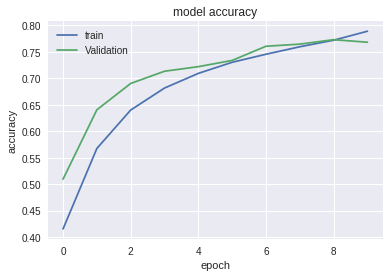

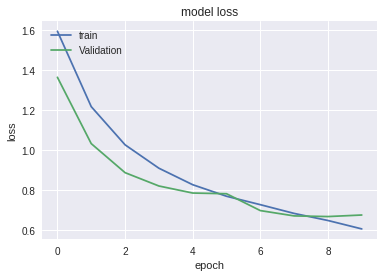

In [15]:
def plot_train_and_val(history):
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'Validation'], loc='upper left')
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'Validation'], loc='upper left')
  plt.show()

# call teh function we just created to plot validation and test accuracy/loss 
plot_train_and_val(history)

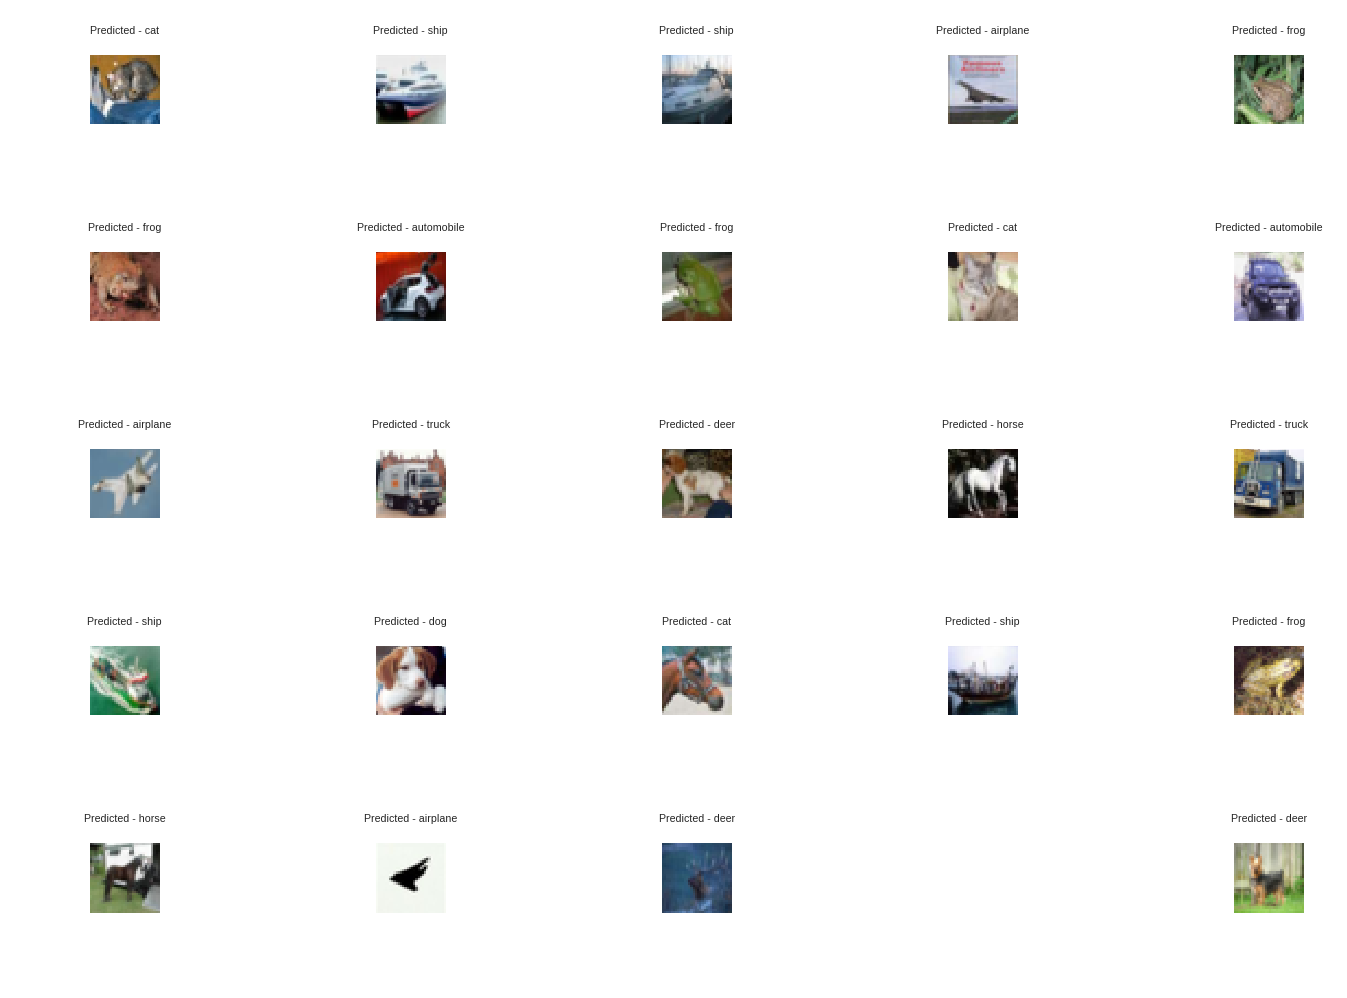

In [16]:
def plot_random_examples():

  plt.figure( dpi=256)
  predicted_classes = model.predict_classes(x_test)

  for i in range(25):
    plt.subplot(5,5,i+1)
    fig=plt.imshow(x_test[i,:,:,:])
    plt.axis('off')
    plt.title("Predicted - {}".format(cifar_labels[predicted_classes[i]]),fontsize=3)
    plt.tight_layout()
    
plot_random_examples()

In [17]:
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

stop_early = keras.callbacks.EarlyStopping(monitor='val_acc', patience=4, verbose=1 )

history=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.15,
          callbacks=[stop_early],
          shuffle=True) 

Train on 42500 samples, validate on 7500 samples
Epoch 1/100
42500/42500 [==============================] - 13s 315us/step - loss: 0.5785 - acc: 0.7966 - val_loss: 0.6535 - val_acc: 0.7781
Epoch 2/100
42500/42500 [==============================] - 13s 297us/step - loss: 0.5638 - acc: 0.8025 - val_loss: 0.6238 - val_acc: 0.7877
Epoch 3/100
42500/42500 [==============================] - 13s 295us/step - loss: 0.5373 - acc: 0.8130 - val_loss: 0.6364 - val_acc: 0.7843
Epoch 4/100
42500/42500 [==============================] - 13s 295us/step - loss: 0.5090 - acc: 0.8195 - val_loss: 0.6174 - val_acc: 0.7931
Epoch 5/100
42500/42500 [==============================] - 13s 296us/step - loss: 0.4986 - acc: 0.8250 - val_loss: 0.6345 - val_acc: 0.7899
Epoch 6/100
42500/42500 [==============================] - 13s 296us/step - loss: 0.4767 - acc: 0.8318 - val_loss: 0.6520 - val_acc: 0.7900
Epoch 7/100
42500/42500 [==============================] - 13s 296us/step - loss: 0.4581 - acc: 0.8377 - val_lo

10000/10000 [==============================] - 1s 145us/step
Test loss: 0.69
Test accuracy: 0.78


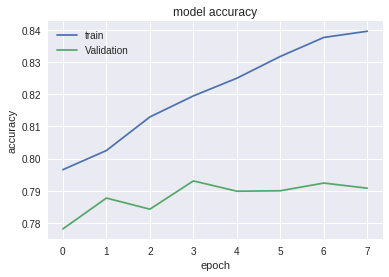

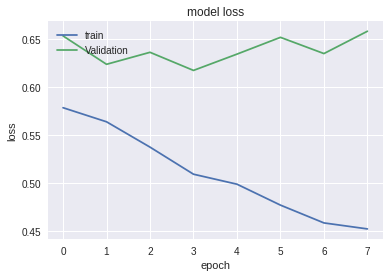

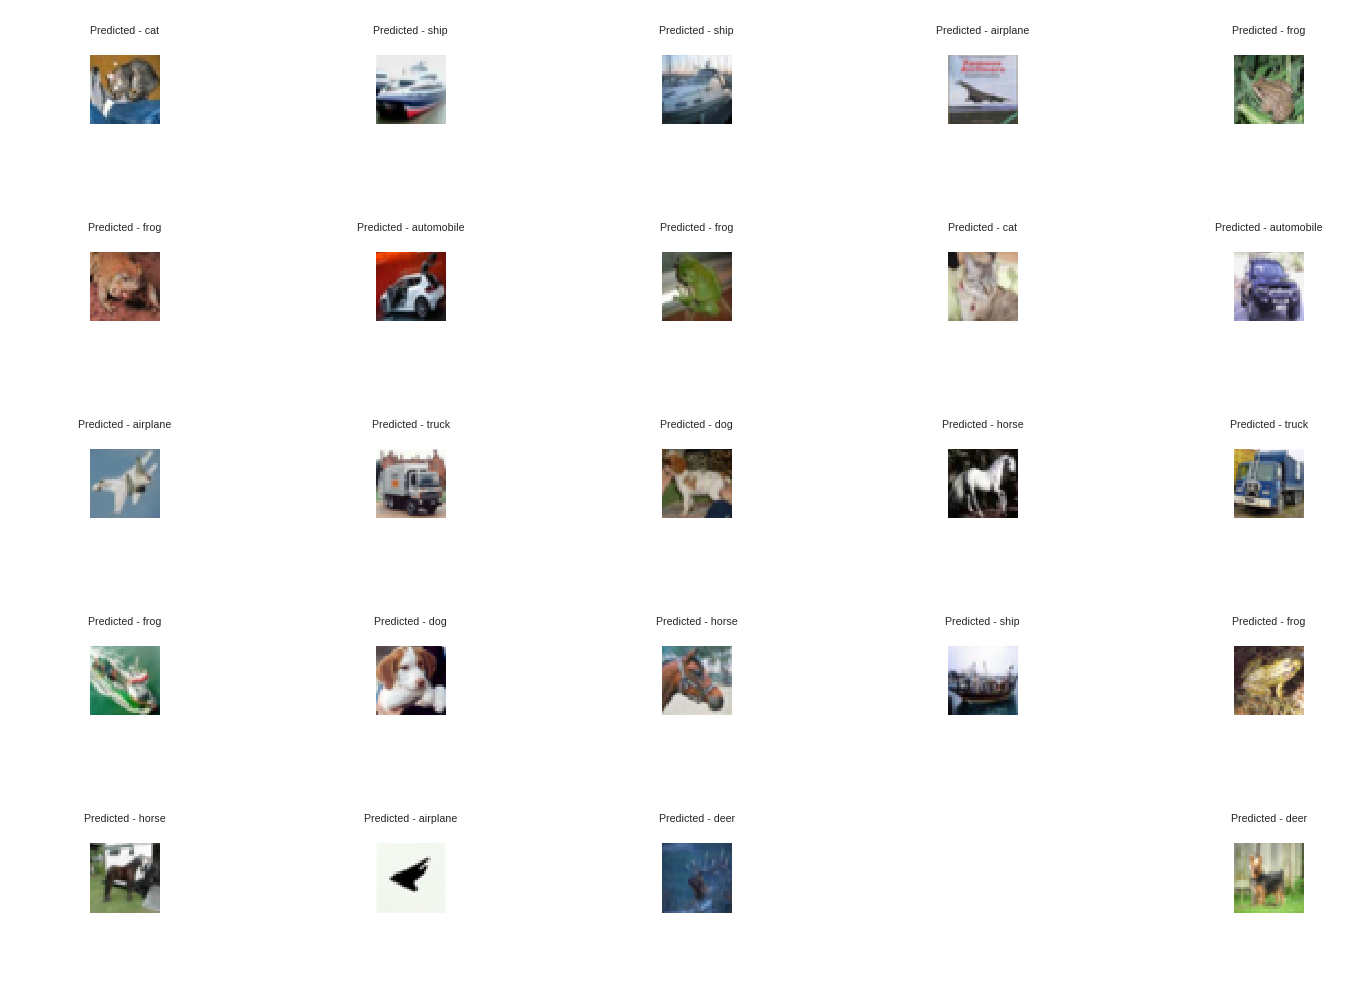

In [19]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss: %.2f' %scores[0])
print('Test accuracy: %.2f' %scores[1])

plot_train_and_val(history)
plot_random_examples()

In [20]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
activation_8 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
__________

In [21]:
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

stop_early = keras.callbacks.EarlyStopping(monitor='val_acc', patience=4, verbose=1 )

history=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.15,
          callbacks=[stop_early],
          shuffle=True) 


Train on 42500 samples, validate on 7500 samples
Epoch 1/100
42500/42500 [==============================] - 10s 236us/step - loss: 1.5746 - acc: 0.4293 - val_loss: 1.2768 - val_acc: 0.5651
Epoch 2/100
42500/42500 [==============================] - 9s 223us/step - loss: 1.2216 - acc: 0.5667 - val_loss: 1.1554 - val_acc: 0.5959
Epoch 3/100
42500/42500 [==============================] - 9s 223us/step - loss: 1.0956 - acc: 0.6135 - val_loss: 1.0411 - val_acc: 0.6329
Epoch 4/100
42500/42500 [==============================] - 10s 224us/step - loss: 1.0068 - acc: 0.6450 - val_loss: 0.9185 - val_acc: 0.6828
Epoch 5/100
42500/42500 [==============================] - 9s 222us/step - loss: 0.9472 - acc: 0.6691 - val_loss: 0.8840 - val_acc: 0.6943
Epoch 6/100
42500/42500 [==============================] - 9s 223us/step - loss: 0.8873 - acc: 0.6868 - val_loss: 0.8498 - val_acc: 0.7052
Epoch 7/100
42500/42500 [==============================] - 9s 223us/step - loss: 0.8409 - acc: 0.7045 - val_loss: 0

10000/10000 [==============================] - 1s 108us/step
Test loss: 0.78
Test accuracy: 0.74


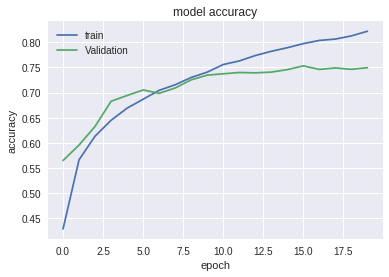

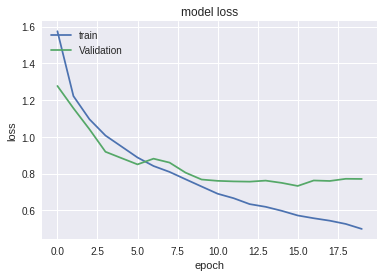

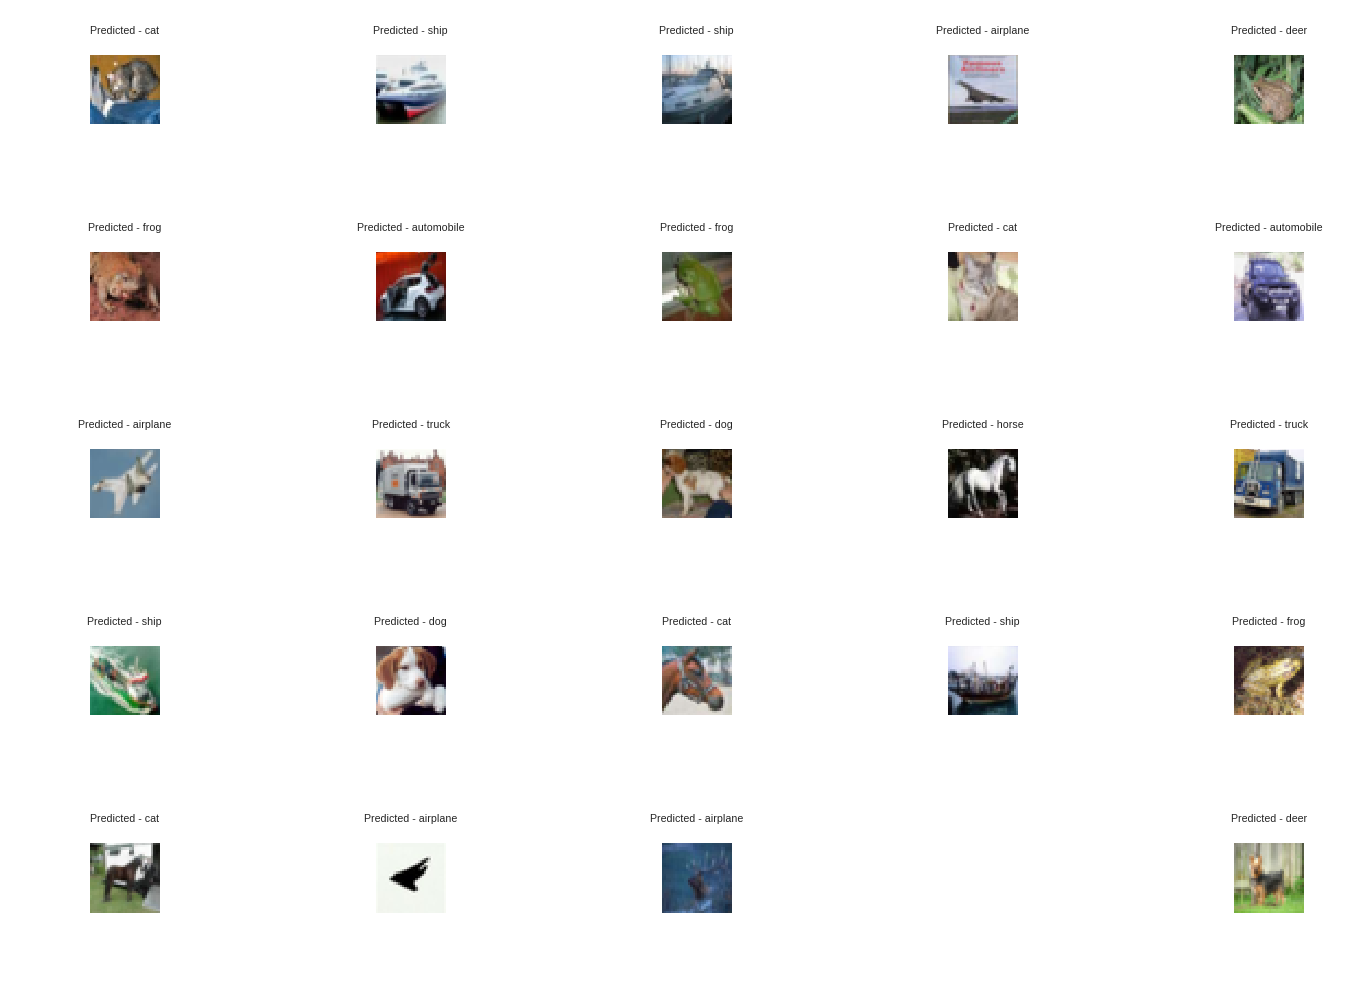

In [22]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss: %0.2f' %scores[0])
print('Test accuracy: %0.2f' %scores[1])

plot_train_and_val(history)
plot_random_examples()


In [24]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_17 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_18 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 15, 15, 64)        18496     
__________

In [25]:
opt = keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

stop_early = keras.callbacks.EarlyStopping(monitor='val_acc', patience=4, verbose=1 )

history=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.15,
          callbacks=[stop_early],
          shuffle=True) 

Train on 42500 samples, validate on 7500 samples
Epoch 1/100
42500/42500 [==============================] - 14s 318us/step - loss: 2.3038 - acc: 0.0984 - val_loss: 2.3034 - val_acc: 0.0972
Epoch 2/100
42500/42500 [==============================] - 13s 297us/step - loss: 2.3031 - acc: 0.0977 - val_loss: 2.3032 - val_acc: 0.0975
Epoch 3/100
42500/42500 [==============================] - 13s 296us/step - loss: 2.3032 - acc: 0.0994 - val_loss: 2.3028 - val_acc: 0.0999
Epoch 4/100
42500/42500 [==============================] - 13s 297us/step - loss: 2.3031 - acc: 0.0987 - val_loss: 2.3030 - val_acc: 0.1008
Epoch 5/100
42500/42500 [==============================] - 13s 297us/step - loss: 2.3031 - acc: 0.0997 - val_loss: 2.3028 - val_acc: 0.0953
Epoch 6/100
42500/42500 [==============================] - 13s 297us/step - loss: 2.3031 - acc: 0.1010 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 7/100
42500/42500 [==============================] - 13s 297us/step - loss: 2.3031 - acc: 0.0996 - val_lo

10000/10000 [==============================] - 1s 146us/step
Test loss: 2.30
Test accuracy: 0.2f


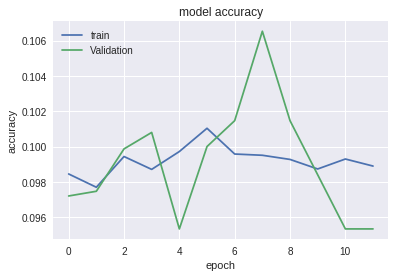

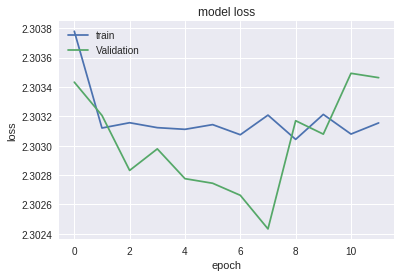

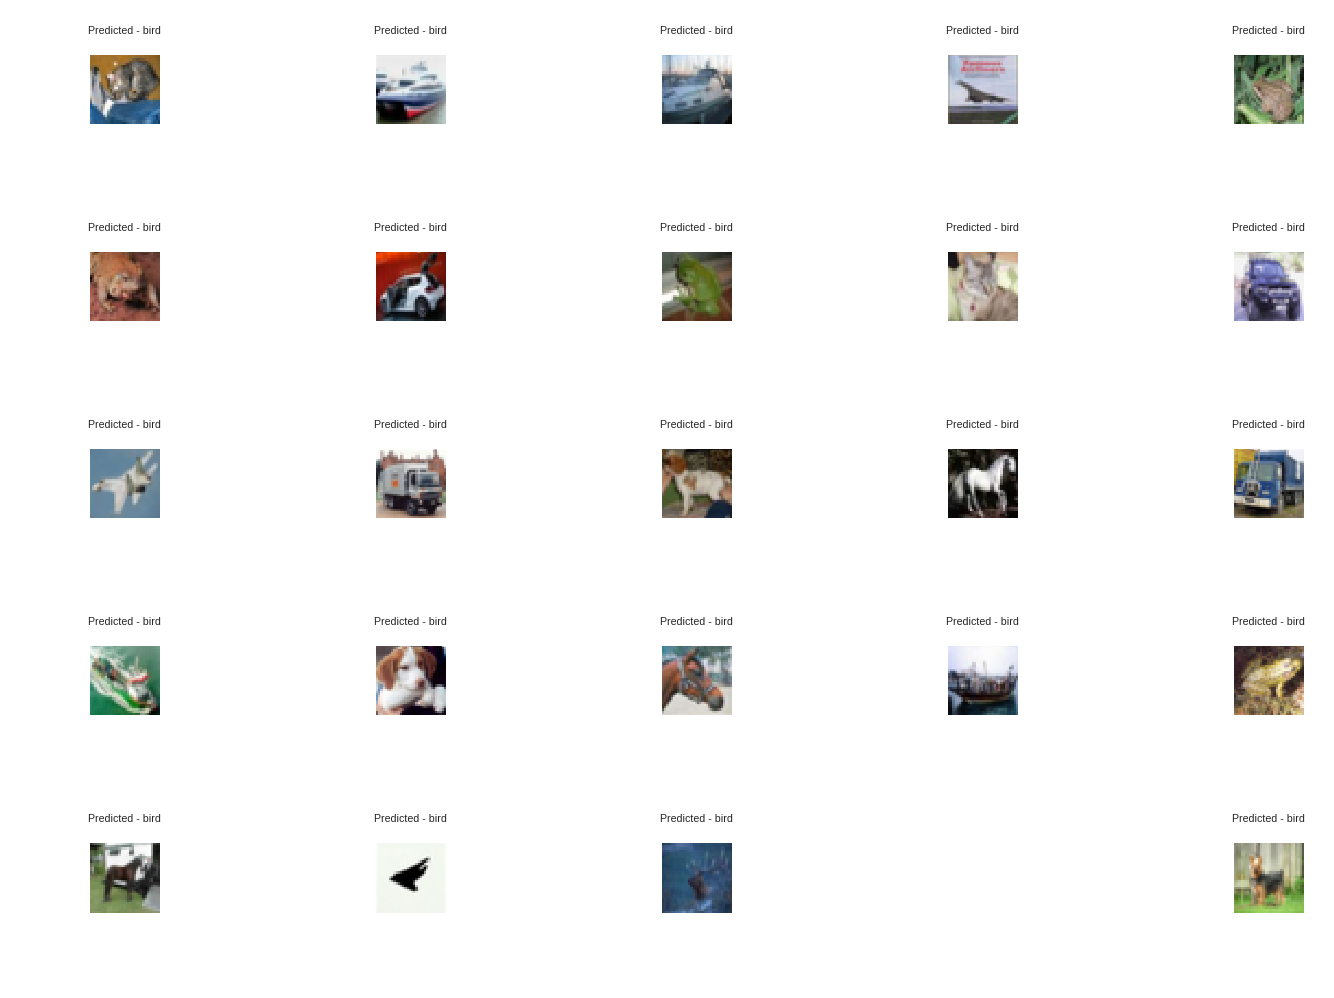

In [26]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss: %0.2f' %scores[0])
print('Test accuracy: 0.2f' %scores[1])

plot_train_and_val(history)
plot_random_examples()


In [0]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [29]:
opt = keras.optimizers.Adam(lr=0.00001, beta_1=0.8, beta_2=0.9)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

stop_early = keras.callbacks.EarlyStopping(monitor='val_acc', patience=4, verbose=1 )

history=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.15,
          callbacks=[stop_early],
          shuffle=True) 

Train on 42500 samples, validate on 7500 samples
Epoch 1/100
42500/42500 [==============================] - 14s 328us/step - loss: 1.0536 - acc: 0.6294 - val_loss: 1.0104 - val_acc: 0.6473
Epoch 2/100
42500/42500 [==============================] - 13s 304us/step - loss: 1.0487 - acc: 0.6313 - val_loss: 1.0074 - val_acc: 0.6513
Epoch 3/100
42500/42500 [==============================] - 13s 305us/step - loss: 1.0456 - acc: 0.6344 - val_loss: 1.0000 - val_acc: 0.6528
Epoch 4/100
42500/42500 [==============================] - 13s 300us/step - loss: 1.0411 - acc: 0.6317 - val_loss: 1.0026 - val_acc: 0.6521
Epoch 5/100
42500/42500 [==============================] - 13s 300us/step - loss: 1.0389 - acc: 0.6351 - val_loss: 0.9917 - val_acc: 0.6539
Epoch 6/100
42500/42500 [==============================] - 13s 300us/step - loss: 1.0320 - acc: 0.6368 - val_loss: 0.9889 - val_acc: 0.6556
Epoch 7/100
42500/42500 [==============================] - 13s 300us/step - loss: 1.0280 - acc: 0.6396 - val_lo

10000/10000 [==============================] - 1s 149us/step
Test loss: 0.88
Test accuracy: 0.69


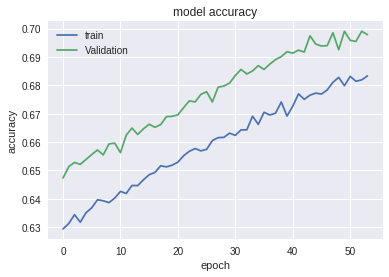

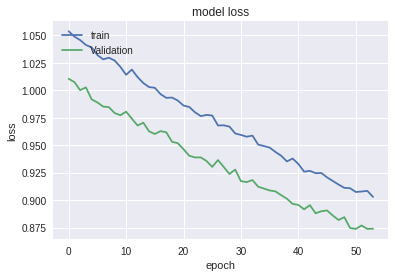

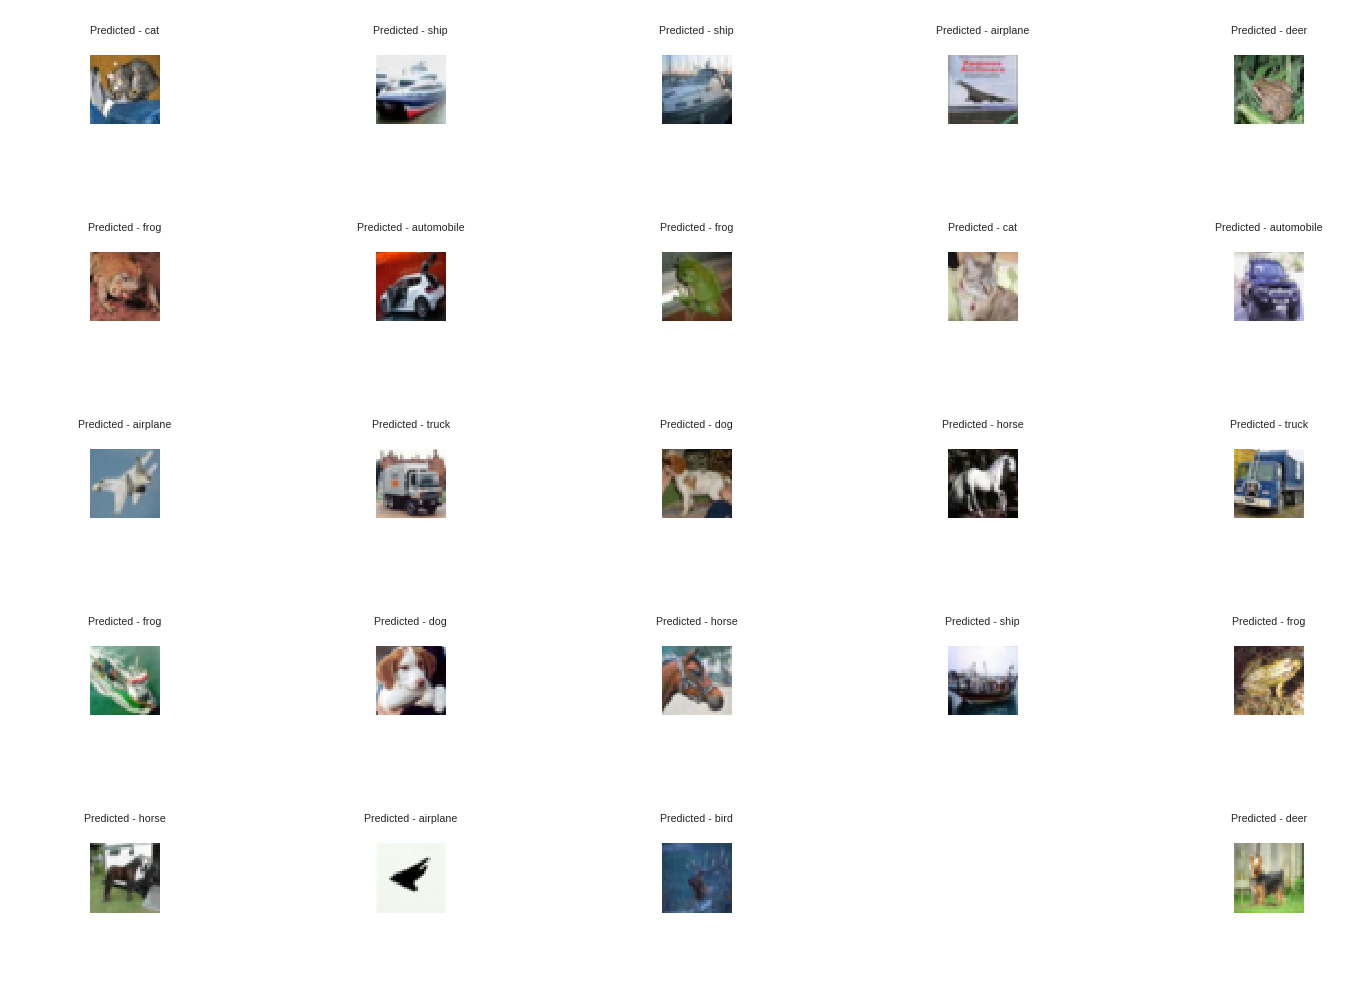

In [30]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss: %0.2f' %scores[0])
print('Test accuracy: %0.2f' %scores[1])

plot_train_and_val(history)
plot_random_examples()
